# Imports

In [1]:
import tensorflow as tf
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import Sequential
from tensorflow.keras.utils import plot_model
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.utils import image_dataset_from_directory

import os
import imghdr

# Limiting GPU usage for TensorFlow

In [2]:
gpus = tf.config.list_physical_devices("GPU")
for i in gpus:
    tf.config.experimental.set_memory_growth(i, True)

# Getting rid of invalid images 

In [3]:
img_folder = "images"
img_extensions = ["jpeg", "jpg", "png", "bmp"]

In [4]:
for image_class in os.listdir(img_folder):
    if not image_class == ".DS_Store":
        for image in os.listdir(os.path.join(img_folder,image_class)):
            img_path = os.path.join(img_folder, image_class, image)
            
            try:
                img = cv2.imread(img_path)
                ext = imghdr.what(img_path) 

                if not ext in img_extensions:
                    print(f"Image extenstion is bad: {img_path}")
                    os.remove(img_path)
            except:
                print(f"Image could not be open: {img_path}")
                os.remove(img_path)

# Converting data to a database

In [25]:
data = image_dataset_from_directory(img_folder, batch_size=16)
data

Found 305 files belonging to 2 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [26]:
# Creating a data iterator
data_iterator = data.as_numpy_iterator()

In [27]:
# Creating batches of images
batch = data_iterator.next()
batch[1]

array([0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1], dtype=int32)

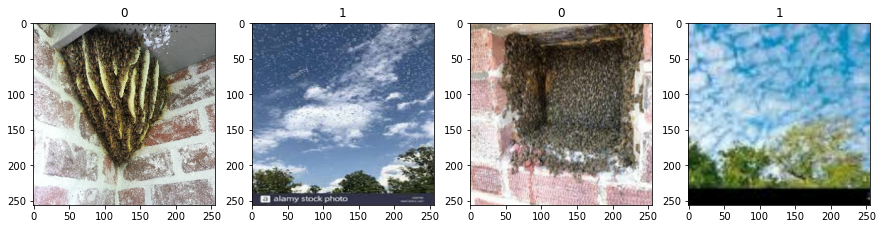

In [28]:
# Visualizing some of our images
fig, ax = plt.subplots(ncols=4, figsize=(15,7))
for i, img in enumerate(batch[0][:4]):
    ax[i].imshow(img.astype(int))
    ax[i].title.set_text(batch[1][i])


# Scaling Down Images

In [29]:
data = data.map(lambda x,y: (x/255, y))

In [30]:
batch = data.as_numpy_iterator().next()

# Splitting the data

In [42]:
# Setting the size of train, validation and test sets
train_size = int(0.8 * len(data))
val_size = int(0.1 * len(data)) 
test_size = int(0.1 * len(data)) 
print(train_size, val_size, test_size)



16 2 2


In [43]:
# Actually splitting the data
train_data = data.take(train_size)
val_data = data.skip(train_size).take(val_size)
test_data = data.skip(train_size + val_size)

# Training the model

In [44]:
logs = "logs"

In [47]:
# Set random seed for reproducibility
tf.random.set_seed(42)

# Create a model
model1 = Sequential([
    Conv2D(16, (3,3), activation="relu", input_shape=(256, 256, 3)),
    MaxPool2D(2,2),

    Conv2D(32, (3,3), activation="relu"),
    MaxPool2D(2,2),

    Conv2D(16, (3,3), activation="relu"),
    MaxPool2D(2,2),

    Flatten(),

    Dense(256, activation="relu"),
    Dense(1, activation="sigmoid")
])

# Compile the model
model1.compile(
    loss = "binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(0.01),
    metrics=["accuracy", tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

callbacks = tf.keras.callbacks.TensorBoard(log_dir=logs)

# Fit the model
hist1 = model1.fit(train_data, validation_data=val_data, epochs=20, callbacks=[callbacks])



Epoch 1/20


2022-05-27 18:21:46.996171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - ETA: 0s - loss: 1.9855 - accuracy: 0.5703 - recall_1: 0.1250 - precision_1: 0.4062

2022-05-27 18:21:51.412896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 7s 230ms/step - loss: 1.9855 - accuracy: 0.5703 - recall_1: 0.1250 - precision_1: 0.4062 - val_loss: 0.7081 - val_accuracy: 0.4375 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 2/20
16/16 [==============================] - 5s 227ms/step - loss: 0.6929 - accuracy: 0.5547 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00 - val_loss: 0.6756 - val_accuracy: 0.5938 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 3/20
16/16 [==============================] - 4s 197ms/step - loss: 0.6819 - accuracy: 0.5742 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00 - val_loss: 0.6700 - val_accuracy: 0.6250 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 4/20
16/16 [==============================] - 4s 202ms/step - loss: 0.6862 - accuracy: 0.5625 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00 - val_loss: 0.7211 - val_accuracy: 0.4062 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 5/20
16/16 [=========

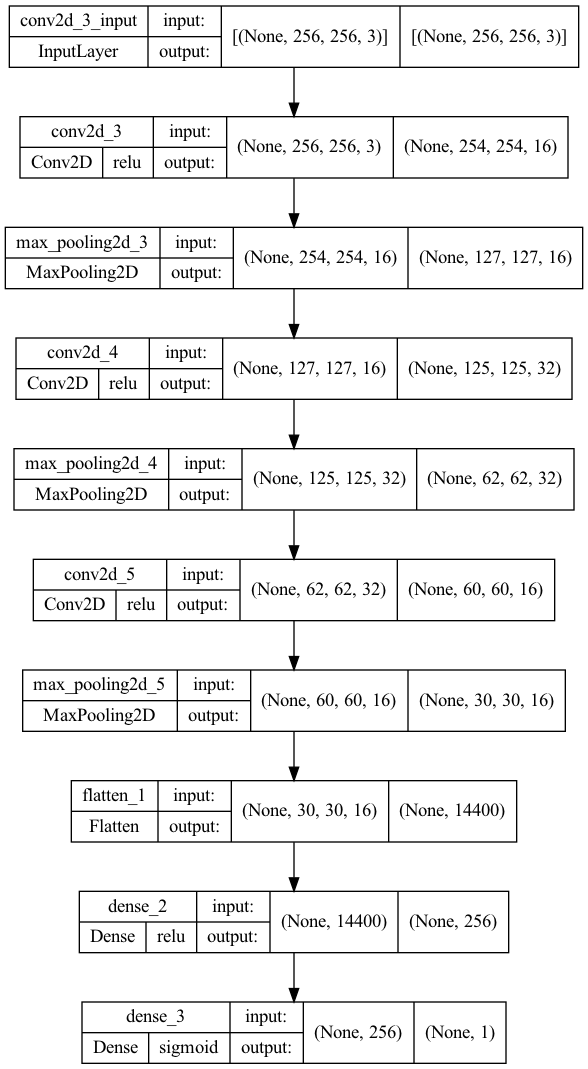

In [71]:
# Plotting the model's architecture
plot_model(model1, show_shapes=True, show_layer_activations=True)

In [72]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

In [49]:
# Evaluate the model
model1.evaluate(test_data)

2/2 [==============================] - 2s 55ms/step - loss: 0.7128 - accuracy: 0.4706 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00


[0.7128146886825562, 0.47058823704719543, 0.0, 0.0]

In [52]:
hist1.history.keys()

dict_keys(['loss', 'accuracy', 'recall_1', 'precision_1', 'val_loss', 'val_accuracy', 'val_recall_1', 'val_precision_1'])

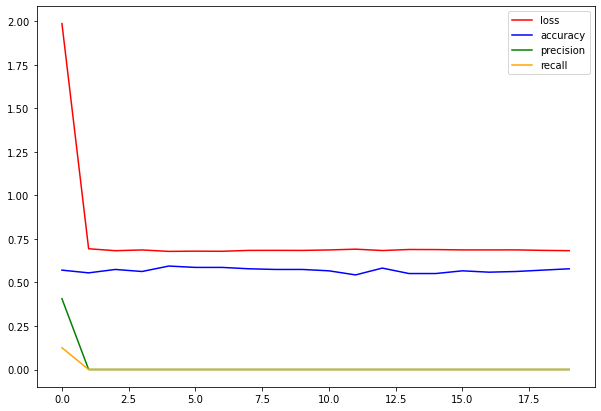

In [64]:
hist1_df = pd.DataFrame(hist1.history)
plt.figure(figsize=(10,7))
plt.plot(hist1_df["loss"],label="loss", color="red")
plt.plot(hist1_df["accuracy"], label="accuracy", c="blue")
plt.plot(hist1_df["precision_1"], label="precision", c="green")
plt.plot(hist1_df["recall_1"], label="recall", c="orange")
plt.legend();


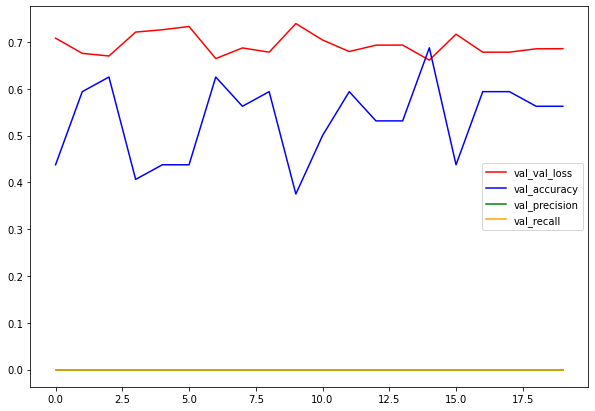

In [66]:
hist1_df = pd.DataFrame(hist1.history)
plt.figure(figsize=(10,7))
plt.plot(hist1_df["val_loss"],label="val_val_loss", color="red")
plt.plot(hist1_df["val_accuracy"], label="val_accuracy", c="blue")
plt.plot(hist1_df["val_precision_1"], label="val_precision", c="green")
plt.plot(hist1_df["val_recall_1"], label="val_recall", c="orange")
plt.legend();

# Creating model 2

In [67]:
logs2 = "logs2"

In [70]:
# Set random seed for reproducibility
tf.random.set_seed(42)

# Create 2nd model
model2 = Sequential([
    Conv2D(16, (3,3), activation="relu", input_shape=(256, 256, 3)),
    MaxPool2D(2,2),

    Conv2D(32, (3,3), activation="relu"),
    MaxPool2D(2,2),

    Conv2D(16, (3,3), activation="relu"),
    MaxPool2D(2,2),

    Flatten(),

    Dense(256, activation="relu"),
    Dense(128, activation="relu"),
    Dense(1, activation="sigmoid")
])

# Compile the model
model2.compile(
    loss = "binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=["accuracy", tf.keras.metrics.Recall(), tf.keras.metrics.Precision()],
)

# Add callbacks for the second model
callbacks2 = tf.keras.callbacks.TensorBoard(log_dir=logs2)

# Fit the model
hist2 = model2.fit(train_data, validation_data=val_data, epochs=100, callbacks=[callbacks2])

Epoch 1/100


2022-05-27 18:33:58.591822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - ETA: 0s - loss: 1.0548 - accuracy: 0.5117 - recall_2: 0.2091 - precision_2: 0.3770

2022-05-27 18:34:03.599902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 7s 205ms/step - loss: 1.0548 - accuracy: 0.5117 - recall_2: 0.2091 - precision_2: 0.3770 - val_loss: 0.6733 - val_accuracy: 0.6250 - val_recall_2: 0.0000e+00 - val_precision_2: 0.0000e+00
Epoch 2/100
16/16 [==============================] - 4s 179ms/step - loss: 0.6478 - accuracy: 0.6250 - recall_2: 0.1698 - precision_2: 0.6923 - val_loss: 0.6094 - val_accuracy: 0.5938 - val_recall_2: 0.0000e+00 - val_precision_2: 0.0000e+00
Epoch 3/100
16/16 [==============================] - 3s 166ms/step - loss: 0.5323 - accuracy: 0.7422 - recall_2: 0.6091 - precision_2: 0.7444 - val_loss: 0.3755 - val_accuracy: 0.9062 - val_recall_2: 1.0000 - val_precision_2: 0.8333
Epoch 4/100
16/16 [==============================] - 4s 173ms/step - loss: 0.4501 - accuracy: 0.7773 - recall_2: 0.8286 - precision_2: 0.6905 - val_loss: 0.4117 - val_accuracy: 0.8125 - val_recall_2: 0.9286 - val_precision_2: 0.7222
Epoch 5/100
16/16 [==============================] - 4s 175ms/st

In [75]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 30, 30, 16)      

In [74]:
# Evaluate the second model
model2.evaluate(test_data)


2/2 [==============================] - 2s 392ms/step - loss: 4.2627e-06 - accuracy: 1.0000 - recall_2: 1.0000 - precision_2: 1.0000


[4.2627143557183444e-06, 1.0, 1.0, 1.0]

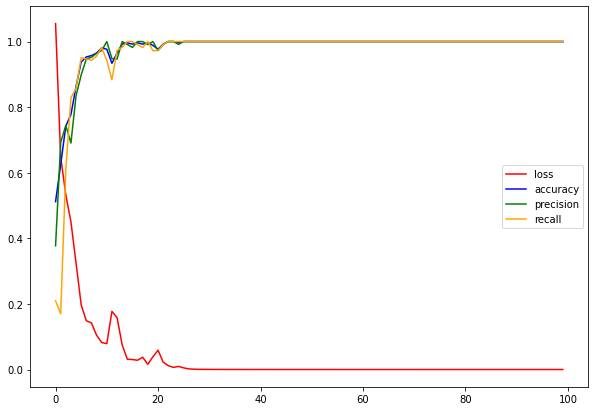

In [77]:
hist2_df = pd.DataFrame(hist2.history)
plt.figure(figsize=(10,7))
plt.plot(hist2_df["loss"],label="loss", color="red")
plt.plot(hist2_df["accuracy"], label="accuracy", c="blue")
plt.plot(hist2_df["precision_2"], label="precision", c="green")
plt.plot(hist2_df["recall_2"], label="recall", c="orange")
plt.legend();


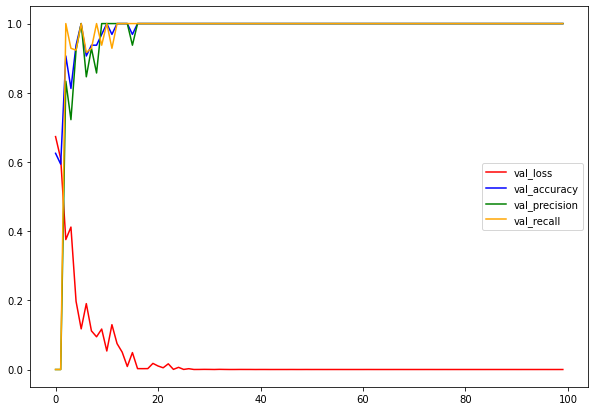

In [78]:
# Plot validation loss and accuracy
plt.figure(figsize=(10,7))
plt.plot(hist2_df["val_loss"],label="val_loss", color="red")
plt.plot(hist2_df["val_accuracy"], label="val_accuracy", c="blue")
plt.plot(hist2_df["val_precision_2"], label="val_precision", c="green")
plt.plot(hist2_df["val_recall_2"], label="val_recall", c="orange")
plt.legend();

In [85]:
# Predicting on random bee swarming images from the internet
def predict_bee_swarming(img_path):
    img = cv2.imread(img_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    # Resizing the image
    resized = tf.image.resize(img, (256,256))

    # Actually classifying the image
    yhat = model2.predict(tf.expand_dims(resized/255, axis=0))

    if yhat < 0.5:
        print("This image is not bee swarming")
    else:
        print("This image is bee swarming")

This image is not bee swarming


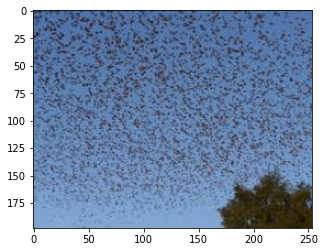

In [95]:
predict_bee_swarming("/Users/andriievskyi/Downloads/images-4.jpeg")